In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import re

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')
from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("russian")
from string import punctuation

!pip uninstall pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem
!cp mystem /bin
!pip install pymystem3

from pymystem3 import Mystem
mystem = Mystem() 

!pip install catboost
from catboost import CatBoostRegressor, Pool

#print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Uninstalling pymystem3-0.2.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pymystem3-0.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pymystem3/*
Proceed (y/n)? y
  Successfully uninstalled pymystem3-0.2.0
--2020-10-12 14:59:27--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.245, 5.45.205.244, 5.45.205.243, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.245|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm902.cdn.yandex.net/download.cdn.yandex.net/mys

**Работаем с Tensorflow v2**

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "denisshustov" # username from the json file
os.environ['KAGGLE_KEY'] = "0bbdc4c0f00de99397e51e13e520ceaf" # key from the json file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q kaggle==1.5.8
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

Processing /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c/kaggle-1.5.8-cp36-none-any.whl
  Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8


In [ ]:
!kaggle competitions download -c sf-dst-car-price-prediction-part2

sf-dst-car-price-prediction-part2.zip: Skipping, found more recently modified local copy (use --force to force download)


# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%
DEL = 1
IMG_SIZE             = 240 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, int(IMG_SIZE / DEL), IMG_CHANNELS)

DATA_PATH = '../content/'
PATH = "../working/car_price/" # рабочая директория

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
#os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0
tf.compat.v1.set_random_seed(RANDOM_SEED)

# EDA / Анализ данных

In [ ]:
print('Распаковываем содержимое')
# Will unzip the files so that you can see them..
with zipfile.ZipFile("../content/sf-dst-car-price-prediction-part2.zip","r") as z:
  z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем содержимое
['images_1_split.hdf5', 'nlp_1_split.hdf5', 'table_0_split.hdf5', 'tables.hdf5', 'table_2_split.hdf5', 'table_6_split.hdf5', 'best_model.hdf5', 'table_5_split.hdf5', 'images_6_split.hdf5', 'model_2_split.hdf5', 'nlp_6_split.hdf5', 'images_3_split.hdf5', 'nlp_4_split.hdf5', 'table_1_split.hdf5', 'images_0_split.hdf5', 'model_1_split.hdf5', 'model_6_split.hdf5', 'images_4_split.hdf5', 'nlp_2_split.hdf5', 'sample_submission.csv', 'images_5_split.hdf5', 'nlp_3_split.hdf5', 'test.csv', 'img', 'nlp_5_split.hdf5', 'table_3_split.hdf5', 'train.csv', 'model_0_split.hdf5', 'model_5_split.hdf5', 'table_4_split.hdf5', 'images_2_split.hdf5', 'model_4_split.hdf5', 'nlp_0_split.hdf5', 'model_3_split.hdf5']


In [ ]:
df = pd.read_csv(PATH+"train.csv")
dft = pd.read_csv(PATH+"test.csv")
sample_submission = pd.read_csv(PATH+"sample_submission.csv")
sample_submission.head()

,sell_id,price
0,1099427284,0
1,1096405886,0
2,1100195294,0
3,1099827282,0
4,1100076198,0


In [ ]:
dft['price'] = np.nan
dft = dft.append(df, sort=False).reset_index(drop=True)

In [ ]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [ ]:
cols = list(dft.columns)

dft['fuelType'] = dft.apply(lambda x: re.findall(r'\w+', x.fuelType)[-1].lower(), axis = 1)

dft['engineDisplacement'] = dft.apply(lambda x: 0 if x.fuelType == 'электро' else float(x.engineDisplacement[:3]), axis = 1)
# dft['engineDisplacement'] = dft['engineDisplacement'].apply(lambda x: float(x[:3]) if x[:3] != 'und' else 0)
dft['enginePower'] = dft.apply(lambda x: int(x.enginePower[:3]), axis = 1)

In [ ]:
dft['Владение'].value_counts()

1 год и 2 месяца      67
1 год и 8 месяцев     67
1 год                 55
1 год и 10 месяцев    52
9 месяцев             52
                      ..
16 лет и 1 месяц       1
29 лет и 7 месяцев     1
16 лет и 4 месяца      1
13 лет и 3 месяца      1
19 лет                 1
Name: Владение, Length: 180, dtype: int64

In [ ]:
'''Преобразуем год выпуска к возрасту'''
dft['years'] = 2021 - dft['productionDate']

'''Объединим бренд и инфо'''
dft['brand'] = dft.apply(lambda x: x.brand + ' ' + x.model_info, axis = 1)


dft['Год'] = dft['Владение']
dft['Мес'] = dft['Владение']

dft['Год'] = dft['Год'].apply(lambda x: 1 if type(x) == str and ('год' in x or 'лет' in x) else 0)
dft['Мес'] = dft['Мес'].apply(lambda x: 1 if type(x) == str and 'мес' in x else 0)
                                        
dft['Владение'] = dft.apply(lambda x: int(re.findall(r'\d', x['Владение'])[0]) * 12 + int(re.findall(r'\d', x['Владение'])[1]) if x['Год'] == 1 and x['Мес'] == 1 else x['Владение'], axis = 1)
dft['Владение'] = dft.apply(lambda x: int(re.findall(r'\d', x['Владение'])[0]) * 12 if x['Год'] == 1 and x['Мес'] == 0 else x['Владение'], axis = 1)
dft['Владение'] = dft.apply(lambda x: int(re.findall(r'\d', x['Владение'])[0]) if x['Год'] == 0 and x['Мес'] == 1 else x['Владение'], axis = 1)

In [ ]:
dft['Владельцы'].value_counts()

3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

In [ ]:
dropcol = ['Год', 'Мес', 'modelDate', 'productionDate', 'model_info', 'vehicleConfiguration', 'Руль']
dft.drop(dropcol, axis = 1, inplace = True)

'''Преобразуем в числовые величины'''
dft['Владельцы'] = dft['Владельцы'].apply(lambda x: int(x[:1]) if type(x) == str else 0)
cleanup_nums = {'ПТС': {'Оригинал': 0, 'Дубликат': 1}}
dft.replace(cleanup_nums, inplace=True)

dft['xDrive'] = dft['name']
dft['xDrive'] = dft['xDrive'].apply(lambda x: 1 if 'xDrive' in x else 0)
dft['name'] = dft['name'].apply(lambda x: x[:x.find(' ')])
# dft['name'] = dft['name'].apply(lambda x: x[:-1] if x[-1] == 's' else x)
# dft['name'] = dft['name'].apply(lambda x: x[:-1] if x[-1] == 'i' or x[-1] == 'd' else x)
# dft['name'] = dft['name'].apply(lambda x: x[:-1] if x[-1] == 's' or x[-1] == 'x' or x[-1] == 'L' else x)
# dft['name'] = dft['name'].apply(lambda x: x[6:] if x[:6] == 'sDrive' or x[:6] == 'xDrive' else x)

dft.loc[dft['name'] == '94Ah', 'name'] = 'Electro'
dft.loc[dft['name'] == 'ActiveHybri', 'name'] = 'Active'

In [ ]:
'''Комплексный параметр'''
dft['mil_y'] = np.log(dft['mileage'] * dft['years'])

In [ ]:
dft.head(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,name,numberOfDoors,sell_id,vehicleTransmission,Владельцы,Владение,ПТС,Привод,price,years,xDrive,mil_y
0,универсал 5 дв.,MERCEDES W124,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0,220,бензин,350000,300,5,1099427284,автоматическая,3,75.0,0,задний,NaN,30,0,16.166886
1,купе,BMW 6ER,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0,313,дизель,15000,640d,2,1096405886,автоматическая,1,78.0,0,полный,NaN,8,1,11.695247
2,купе,BMW 3ER,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5,218,бензин,166600,325xi,2,1100195294,автоматическая,3,NaN,0,полный,NaN,13,0,14.588300
3,седан,BMW 3ER,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0,136,бензин,147000,318i,4,1099827282,автоматическая,2,NaN,0,задний,NaN,14,0,14.537245
4,седан,BMW 5ER,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0,190,дизель,24000,520d,4,1100076198,автоматическая,1,NaN,0,полный,NaN,2,1,10.778956


In [ ]:
def dummy(df, name):
  df = pd.concat([df, pd.get_dummies(df[name])], axis = 1)
  df.drop([name], axis = 1, inplace = True)
  return df

In [ ]:
iskl = ['description', 'price', 'sell_id', 'Владение']
dft_iskl = dft.drop(iskl, axis = 1)

In [ ]:
sc = RobustScaler()
for_enc = ['bodyType', 'brand', 'color', 'fuelType', 'name', 'vehicleTransmission', 'Привод']
cols = dft_iskl.columns
for name in cols:
  if name in for_enc:
    dft_iskl = dummy(dft_iskl, name)
  else:
    dft_iskl[name] = sc.fit_transform(dft_iskl[name].values.reshape(-1, 1))

In [ ]:
X = dft_iskl.loc[~dft['price'].isnull(), :]
y = dft.loc[~dft['price'].isnull(), 'price']

X_sub = dft_iskl.loc[dft['price'].isnull(), :]

In [ ]:
X.head()

,engineDisplacement,enginePower,mileage,numberOfDoors,Владельцы,ПТС,years,xDrive,mil_y,внедорожник 3 дв.,внедорожник 5 дв.,внедорожник открытый,кабриолет,компактвэн,купе,купе-хардтоп,лимузин,лифтбек,минивэн,пикап двойная кабина,родстер,седан,седан 2 дв.,универсал 5 дв.,хэтчбек 3 дв.,хэтчбек 5 дв.,AUDI 100,AUDI A1,AUDI A3,AUDI A4,AUDI A4_ALLROAD,AUDI A5,AUDI A6,AUDI A7,AUDI A8,AUDI ALLROAD,AUDI COUPE,AUDI Q3,AUDI Q5,AUDI Q7,...,Brabus,C,Competition,Electro,GT,L1,L2,L3,Long,M135i,M40i,M50d,M50i,M550d,M550i,M760Li,M850i,Pullman,R,S,S-tronic,S4,Tiptronic,V10,V8,clean,sDrive18i,sDrive20i,tiptronic,ultra,xDrive18d,xDrive20d,xDrive20i,автоматическая,вариатор,механическая,роботизированная,задний,передний,полный
1671,0.2,0.336066,1.248317,0.0,0.5,0.0,0.857143,0.0,0.771110,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1672,0.0,-0.221311,0.673380,0.0,0.0,0.0,0.285714,0.0,0.406007,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1673,0.7,0.614754,0.114514,0.0,0.5,0.0,0.000000,0.0,0.044172,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1674,-0.8,-0.418033,0.376639,0.0,0.5,0.0,0.285714,0.0,0.294306,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1675,-1.0,-0.581967,0.274634,1.0,0.5,0.0,0.285714,0.0,0.250349,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SPLIT, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
y_test

5951     539000.0
7646     950000.0
3123    1050000.0
7597     460000.0
7740    1261000.0
          ...    
8134    3197000.0
4102    1370000.0
5020     560000.0
2535     850000.0
6299    1100000.0
Name: price, Length: 1003, dtype: float64

In [ ]:


y_sc_tr = MinMaxScaler(feature_range = (0.25, 0.75))
y_transform = y
y_transform = np.log(y_transform)
y_transform = y_sc_tr.fit_transform(y_transform.values.reshape(-1, 1))

# y_train = np.log(y_train)
# y_test = np.log(y_test)
# y_sc = MinMaxScaler(feature_range = (0.2, 0.8))
# y_train = y_sc.fit_transform(y_train.values.reshape(-1, 1))
# y_test = y_sc.transform(y_test.values.reshape(-1, 1))

In [ ]:
# y_train = np.log(y_train)
# y_test = np.log(y_test)
# max_y = np.max(y_train)
# y_train = y_train / max_y
# y_test = y_test / max_y

In [ ]:
y_train

7320    1200000.0
8037    3500000.0
4681     395000.0
6014     430000.0
3649    2200000.0
          ...    
5443    3499000.0
6862    2899000.0
6897    1180000.0
7061    3200000.0
2531     659000.0
Name: price, Length: 5679, dtype: float64

In [ ]:
EPOCHS               = 150
LR                   = 5e-3
BATCH_SIZE           = 1024

# 1e-3 150   13.57 0.2..0.8
# 5e-3 150   12.47 0.2..0.8
# 5e-3 250   12.89 0.2..0.8
# 1e-3 250   13.55 0.2..0.8
# 5e-3 150   12.71 0.1..0.9
# 5e-3 150   12.61 0.3..0.7
# 5e-3 150   12.30 0.25..0.75

In [ ]:
def tab_mod_create(num_enc):
    tab_enc = M.Sequential([
        L.Input(X.shape[1]),

        L.Dense(1024, activation = 'selu'),
        # L.Dropout(0.1),    
        L.BatchNormalization(),

        L.LeakyReLU(),

        L.Dense(50, activation = 'selu'),
        # L.Dropout(0.1),
        L.BatchNormalization(),

        L.Dense(1024, activation = 'selu'),
        # L.Dropout(0.1),
        L.BatchNormalization(),

        L.Dense(num_enc, activation = 'selu')])

    tab_dec = M.Sequential([
        L.Input(num_enc),
        L.Dense(1, activation = 'sigmoid')])

    tables = M.Sequential([tab_enc, tab_dec])
    tables.compile(optimizer=optimizers.Adam(lr=LR), loss='MAPE', metrics=['mse'])
    return tab_enc, tab_dec, tables

In [ ]:
def f_scheduler(epoch, lr):
  if epoch < 100:
    return lr
  elif epoch >= 100 and epoch < 200:
    return lr / 5
  else:
    return lr / 10 

scheduler = LearningRateScheduler(f_scheduler)

checkpoint = ModelCheckpoint(PATH + 'best_model.hdf5', monitor=['val_loss'], mode='min')
callbacks_list = [scheduler, checkpoint]

In [ ]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
X_x = np.zeros((X.shape[0], 8))
Sub_x = np.zeros((X_sub.shape[0], 8))

X_enc = np.zeros((X.shape[0], 75))
Sub_enc = np.zeros((X_sub.shape[0], 75))

In [ ]:
n_fold = 10
kf = KFold(n_splits=n_fold, shuffle = True, random_state = 0)

In [ ]:
mape_list = []
repeat = 10
for n, (train, test) in enumerate(kf.split(X, y_transform)):
    m_min = 100
    for i in range(repeat):
      tab_enc, tab_dec, tables = tab_mod_create(25)
      history = tables.fit(X.iloc[train, :], y_transform[train, :],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X.iloc[test, :], y_transform[test, :]),
                    callbacks=callbacks_list,
                    verbose = 0,                    
                   )
      tables.load_weights(PATH + 'best_model.hdf5')
      test_predict_nn1 =tables.predict(X.iloc[test, :])
      m = mape(np.exp(y_sc_tr.inverse_transform(y_transform[test, :].reshape(-1, 1))), np.exp(y_sc_tr.inverse_transform(test_predict_nn1[:,0].reshape(-1, 1))))
      
      X_x[test, 0] += test_predict_nn1[:,0]
      Sub_x[:, 0] +=  tables.predict(X_sub)[:,0]

      X_enc[test, :25] += tab_enc.predict(X.iloc[test, :])
      Sub_enc[:, :25] +=  tab_enc.predict(X_sub)

      if m < m_min:
        m_min = m        
        tab_enc.save(PATH + f'table_{n}_split.hdf5')
        tables.save(PATH + 'tables.hdf5')
    
    mape_list.append(m_min)
    print(f"TEST mape: {(m_min):0.2f}%")
print(f"TEST mape average: {(np.mean(mape_list)):0.2f}%")

X_x[:, 0] /= repeat
Sub_x[:, 0] /= repeat

X_enc[:, :25] /= repeat
Sub_enc[:, :25] /= repeat

TEST mape: 11.03%
TEST mape: 12.20%
TEST mape: 12.47%
TEST mape: 12.18%
TEST mape: 12.60%
TEST mape: 11.48%
TEST mape: 12.18%
TEST mape: 11.92%
TEST mape: 11.75%
TEST mape: 10.97%
TEST mape average: 11.88%


# Images

(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)


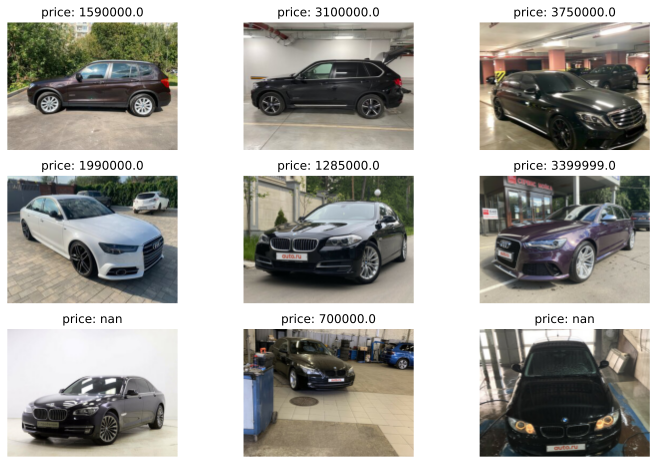

In [ ]:
plt.figure(figsize = (12,8))

random_image = dft.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+'img/img/' + str(path) + '.jpg')
    print(np.array(im).shape)
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

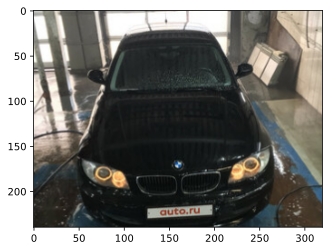

(320, 240)

In [ ]:
image = PIL.Image.open(PATH+'img/img/' + str(path) + '.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Подготовка данных

### Аугментация данных

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-hn27yp6y
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-hn27yp6y
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp36-none-any.whl size=28028 sha256=f559e58311dd49dff47ede3331179ea941042c60e908afb46cc516b1edac16b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-wy417bt_/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor


In [ ]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
        ],p=0.5),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.ChannelShuffle(p=0.05),
    albumentations.OneOf([
        albumentations.ElasticTransform(),
        albumentations.GridDistortion(),
        ], p=0.1),
    albumentations.OneOf([
        albumentations.IAAAdditiveGaussianNoise(),
        albumentations.GaussNoise(),
        ], p=0.2),
    albumentations.OneOf([
        albumentations.MotionBlur(p=.2),
        albumentations.MedianBlur(blur_limit=3, p=0.1),
        albumentations.Blur(blur_limit=(10, 10), p=0.1),
        #albumentations.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.2),
        #albumentations.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=0.1),
        #albumentations.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=0.1),
        #albumentations.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=0.1),
        #albumentations.RandomFog(fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1, p=0.2),
        ], p=0.2),
    albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.5, rotate_limit=20, p=0.2),
    albumentations.OneOf([
        albumentations.CLAHE(clip_limit=2),
        albumentations.IAASharpen(),
        albumentations.IAAEmboss(),
        albumentations.OpticalDistortion(),
        ], p=0.2),
    ], p = 0.7)



### Генерация данных

In [ ]:
def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(dft['sell_id'].iloc[index].values):
        image = cv2.imread(PATH + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)



In [ ]:
images_train = get_image_array(X.iloc[train, :].index)
images_test = get_image_array(X.iloc[test, :].index)
images_sub = get_image_array(X_sub.index)

images shape (6014, 240, 240, 3) dtype uint8
images shape (668, 240, 240, 3) dtype uint8
images shape (1671, 240, 240, 3) dtype uint8


In [ ]:
def process_image(image):
    image = AUGMENTATIONS(image = image.numpy())['image']
    return image

def process_image_resc(image):
    return image

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    image = image / 255
    return (image), price

def tf_process_val_dataset_element(image, price):
    image = image / 255
    return (image), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, y_transform[train]
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, y_transform[test]
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))

sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

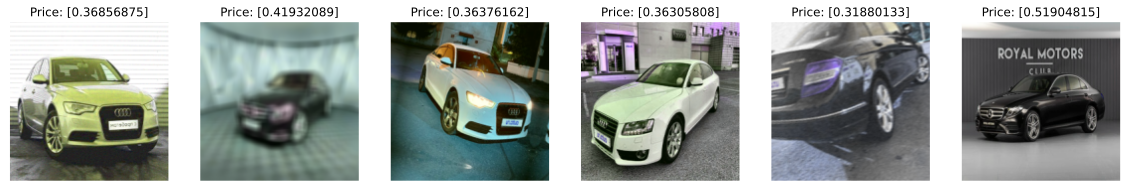

In [ ]:
plt.figure(figsize=(20,5))

# dataset = dataset.take(4).skip(1).take(2).skip(4)

for i in range(0,6):
    xg,yg = train_dataset.take(6).skip(i).__iter__().__next__()
    image = xg
    plt.subplot(1,6, i+1)
    plt.imshow(image)
    plt.title('Price: '+str(yg.numpy()))
    plt.axis('off')
plt.show()

In [ ]:
yg.numpy()

array([0.51904815])

In [ ]:
xg.shape

TensorShape([240, 240, 3])

# Построение модели

In [ ]:
def f_scheduler(epoch, lr):
  if epoch < 15:
      return lr
  elif epoch >= 10 and epoch < 25:
      return lr / 5
  else:
      return lr / 10

scheduler = LearningRateScheduler(f_scheduler)
checkpoint = ModelCheckpoint(PATH + 'best_model.hdf5', monitor=['val_loss'], mode='min')
callbacks_list = [scheduler, checkpoint]

# Добавим признаки SOTA модели

In [ ]:
!pip install efficientnet
import efficientnet.tfkeras as efn

K.clear_session()
base_model = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
EPOCHS               = 25
LR                   = 5e-3
BATCH_SIZE           = 32

In [ ]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

In [ ]:
def img_model_create(num_enc):
  img_enc = M.Sequential([
      base_model,
      L.GlobalAveragePooling2D(),
      
      L.Dense(64, activation = 'selu'),
      # L.Dropout(0.5),
      L.BatchNormalization(),

      L.Dense(num_enc, activation = 'selu')])

  img_dec = M.Sequential([
      L.Input(num_enc),
      L.Dense(1, activation = 'sigmoid')])

  images = M.Sequential([img_enc, img_dec])

  images.compile(optimizer=optimizers.Adam(lr=LR), loss='MAPE', metrics=['mse'])
  return img_enc, img_dec, images

In [ ]:
img_enc, img_dec, images = img_model_create(25)
img_enc.summary()
img_dec.summary()
images.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 8, 8, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                114752    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1625      
Total params: 17,790,449
Trainable params: 116,505
Non-trainable params: 17,673,944
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)    

In [ ]:
for n, (train, test) in enumerate(kf.split(X, y_transform)):

    images_train = get_image_array(X.iloc[train, :].index)
    images_test = get_image_array(X.iloc[test, :].index)
    images_sub = get_image_array(X_sub.index)

    train_dataset = tf.data.Dataset.from_tensor_slices((
        images_train, y_transform[train]
        )).map(tf_process_train_dataset_element)

    test_dataset = tf.data.Dataset.from_tensor_slices((
        images_test, y_transform[test]
        )).map(tf_process_val_dataset_element)

    y_sub = np.zeros(len(X_sub))

    sub_dataset = tf.data.Dataset.from_tensor_slices((
        images_sub, y_sub
        )).map(tf_process_val_dataset_element)

    img_enc, img_dec, images = img_model_create(25)

    history = images.fit(
            train_dataset.batch(BATCH_SIZE),
            epochs=EPOCHS,
            validation_data = test_dataset.batch(BATCH_SIZE),
            callbacks=callbacks_list,
            verbose = 0,
            )
    images.load_weights(PATH + 'best_model.hdf5')
    test_predict_nn2 =images.predict(test_dataset.batch(BATCH_SIZE))
    m = mape(np.exp(y_sc_tr.inverse_transform(y_transform[test, :].reshape(-1, 1))), np.exp(y_sc_tr.inverse_transform(test_predict_nn2[:,0].reshape(-1, 1))))

    X_x[test, 1] = test_predict_nn2[:,0]
    Sub_x[:, 1] += images.predict(sub_dataset.batch(BATCH_SIZE))[:,0]
    img_enc.save(PATH + f'images_{n}_split.hdf5')

    X_enc[test, 25:50] = img_enc.predict(test_dataset.batch(BATCH_SIZE))
    Sub_enc[:, 25:50] +=  img_enc.predict(sub_dataset.batch(BATCH_SIZE))

    print(f"TEST mape: {(m):0.2f}%")



images shape (6013, 240, 240, 3) dtype uint8
images shape (669, 240, 240, 3) dtype uint8
images shape (1671, 240, 240, 3) dtype uint8
TEST mape: 40.65%
images shape (6013, 240, 240, 3) dtype uint8
images shape (669, 240, 240, 3) dtype uint8
images shape (1671, 240, 240, 3) dtype uint8
TEST mape: 42.37%
images shape (6014, 240, 240, 3) dtype uint8
images shape (668, 240, 240, 3) dtype uint8
images shape (1671, 240, 240, 3) dtype uint8
TEST mape: 44.52%
images shape (6014, 240, 240, 3) dtype uint8
images shape (668, 240, 240, 3) dtype uint8
images shape (1671, 240, 240, 3) dtype uint8
TEST mape: 40.85%
images shape (6014, 240, 240, 3) dtype uint8
images shape (668, 240, 240, 3) dtype uint8
images shape (1671, 240, 240, 3) dtype uint8
TEST mape: 42.57%
images shape (6014, 240, 240, 3) dtype uint8
images shape (668, 240, 240, 3) dtype uint8
images shape (1671, 240, 240, 3) dtype uint8
TEST mape: 41.24%
images shape (6014, 240, 240, 3) dtype uint8
images shape (668, 240, 240, 3) dtype uint8

# Обучение целиком

In [ ]:
# EPOCHS               = 15
# LR                   = 1e-4
# BATCH_SIZE           = 16

In [ ]:
# def f_scheduler(epoch, lr):
#   #y1 = np.sin(epoch * np.pi / 180 * 20 - 5) + 1
#   y1 = (np.sin(epoch * 3.14 / 180 * 37  -5) + 1.2) / 2.2
#   #y2 = -0.036 * epoch + 1
#   y2 = (1.013 * np.exp(-0.06 * epoch))
#   return lr * (y1 * y2)

# scheduler = LearningRateScheduler(f_scheduler)
# checkpoint = ModelCheckpoint(PATH + 'best_model.hdf5', monitor=['val_loss'], mode='min')
# callbacks_list = [scheduler, checkpoint]

In [ ]:
# base_model.trainable = True

In [ ]:
# images.compile(optimizer=optimizers.Adam(lr=LR), loss='MAPE', metrics=['MAPE'])

In [ ]:
# history = images.fit(
#         train_dataset.batch(BATCH_SIZE),
#         epochs=EPOCHS,
#         validation_data = test_dataset.batch(BATCH_SIZE),
#         callbacks=callbacks_list,
#         )

In [ ]:
# images.load_weights(PATH + 'best_model.hdf5')
# images.save(PATH + 'images_tune.hdf5')

In [ ]:
# # test_predict_nn2 = images.predict(test_dataset.batch(BATCH_SIZE))
# # print(f"TEST mape: {(mape(np.exp(y_test * max_y), np.exp(test_predict_nn2[:,0] * max_y))):0.2f}%")
# test_predict_nn2 =images.predict(test_dataset.batch(BATCH_SIZE))
# m = mape(np.exp(y_sc_tr.inverse_transform(y_transform[test, :].reshape(-1, 1))), np.exp(y_sc_tr.inverse_transform(test_predict_nn2[:,0].reshape(-1, 1))))
# print(f"TEST mape: {(m):0.2f}%")

# NLP

In [ ]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [ ]:
preprocess_text(dft.loc[0, 'description'])

'привет продавать эксклюзивный проект 124 универсал 300te 24 sportline модель 124.091 300 te 24 двигатель 104.980 трансмиссия 722.359 цвет кузов 040 черный отделка салон 271 кожа черный  / " антрацит ")\n опция 211 автоматический блокировка дифференциал asd 240 индикатор внешний температура 244 спортивный сидение спереди 281 спортивный рулевой колесо отделка кожа диаметр 390 мм кожаный рычаг кпп 291 подушка безопасность водитель передний пассажир 300 дополнительный бардачок вещевой отсек спереди 412 люк электропривод устройство подъем 420 автоматический коробка передача напольный исполнение 440 темпомат круиз контроль 538 автоматический антенна 541 двойной занавеска багажный пространство пасажирский отсек сетка шторка 570 складной подлокотник спереди 586 кондиционер behr электрический стеклоподъемник передний задний дверь 598 атермальный боковой задний стекло задний стекло подогрев esg 650 спортивный подвеска 673 акб увеличивать мощность 812 установленный сзади динамика 873 электрообог

In [ ]:
description_list = []

for i in range(dft.shape[0]):
  description_list.append(preprocess_text(dft.loc[i, 'description']))  


In [ ]:
ind = list(dft.index)

for i in range(dft.shape[0]):
  if ind[i] != i:
    print(ind[i], i)
    break

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(description_list)

In [ ]:
text_train = np.array(description_list)[list(X.iloc[train, :].index)]
text_test = np.array(description_list)[X.iloc[test, :].index]
text_sub = np.array(description_list)[X_sub.index]

In [ ]:
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(6014, 256) (668, 256) (1671, 256)


In [ ]:
print(text_train[2])
print(text_train_sequences[2])

комплект зимний колесо 27.07 2020 замена передний тормозной диск замена масло двигатель коробка весь фильтр замена свеча зажигание машина хороший состояние возможный торг причина продажа связанный покупка жилье
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   

In [ ]:
def nlp_mod_create(num_enc):
    nlp_enc = M.Sequential([
        L.Input(MAX_SEQUENCE_LENGTH),
        L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),

        L.LSTM(256, return_sequences=True),
        L.BatchNormalization(),

        L.LSTM(128, return_sequences=True),
        L.BatchNormalization(),

        L.Dense(512, activation = 'selu'),
        L.Dropout(0.2),    
        L.BatchNormalization(),

        L.Dense(256, activation = 'selu'),
        L.Dropout(0.2),    
        L.BatchNormalization(),

        L.Flatten(),
        L.Dropout(0.5),
        L.Dense(num_enc, activation = 'selu')])

    nlp_dec = M.Sequential([
        L.Input(num_enc),
        L.Dense(1, activation = 'sigmoid')])

    nlp = M.Sequential([nlp_enc, nlp_dec])
    nlp.compile(optimizer=optimizers.Adam(lr=LR), loss='MAPE', metrics=['mse'])
    return nlp_enc, nlp_dec, nlp

In [ ]:
nlp_enc, nlp_dec, nlp = nlp_mod_create(25)
nlp_enc.summary()
nlp_dec.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 256)          5757952   
_________________________________________________________________
lstm (LSTM)                  (None, 256, 256)          525312    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256, 256)          1024      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256, 128)          197120    
_________________________________________________________________
batch_normalization_12 (Batc (None, 256, 128)          512       
_________________________________________________________________
dense_33 (Dense)             (None, 256, 512)          66048     
_________________________________________________________________
dropout (Dropout)            (None, 256, 512)        

In [ ]:
def f_scheduler(epoch, lr):
  if epoch < 50:
    return lr
  elif epoch >= 50 and epoch < 80:
    return lr / 5
  else:
    return lr / 10 

scheduler = LearningRateScheduler(f_scheduler)
checkpoint = ModelCheckpoint(PATH + 'best_model.hdf5', monitor=['val_loss'], mode='min')
callbacks_list = [scheduler, checkpoint]

In [ ]:
EPOCHS               = 100
LR                   = 1e-4
BATCH_SIZE           = 512

In [ ]:
for n, (train, test) in enumerate(kf.split(X, y_transform)):
    
    text_train = np.array(description_list)[list(X.iloc[train, :].index)]
    text_test = np.array(description_list)[X.iloc[test, :].index]
    text_sub = np.array(description_list)[X_sub.index]

    text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
    text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
    text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

    nlp_enc, nlp_dec, nlp = nlp_mod_create(25)
    history = nlp.fit(text_train_sequences, y_transform[train, :],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(text_test_sequences, y_transform[test, :]),
                    callbacks=callbacks_list,
                    verbose = 0,                    
                   )
    nlp.load_weights(PATH + 'best_model.hdf5')
    test_predict_nn3 =nlp.predict(text_test_sequences)
    m = mape(np.exp(y_sc_tr.inverse_transform(y_transform[test, :].reshape(-1, 1))), np.exp(y_sc_tr.inverse_transform(test_predict_nn3[:,0].reshape(-1, 1))))

    X_x[test, 2] = test_predict_nn3[:,0]
    Sub_x[:, 2] += nlp.predict(text_sub_sequences)[:,0]
    nlp_enc.save(PATH + f'nlp_{n}_split.hdf5')

    X_enc[test, 50:] = nlp_enc.predict(text_test_sequences)
    Sub_enc[:, 50:] +=  nlp_enc.predict(text_sub_sequences)

    print(f"TEST mape: {(m):0.2f}%")

TEST mape: 40.84%
TEST mape: 45.43%
TEST mape: 45.04%
TEST mape: 51.62%
TEST mape: 42.69%
TEST mape: 43.84%
TEST mape: 44.82%
TEST mape: 46.48%
TEST mape: 43.85%
TEST mape: 42.82%


# Соединяем энкодеры всех моделей

In [ ]:
def process_image(image):
    image = AUGMENTATIONS(image = image.numpy())['image']
    return image

def process_image_resc(image):
    return image

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    image = image / 255
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    image = image / 255
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X.iloc[train, :], text_train_sequences, y_transform[train]
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test,X.iloc[test, :], text_test_sequences, y_transform[test]
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, text_sub_sequences, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [ ]:
from keras.models import Model
combinedInput = L.concatenate([img_enc.output, tab_enc.output, nlp_enc.output])
# being our regression head
head = L.Dense(50, activation="selu")(combinedInput)
L.BatchNormalization(),
head = L.Dense(25, activation="selu")(head)
head = L.Dense(1, activation="sigmoid")(head)

In [ ]:
nlp_enc.save(PATH + f'nlp_{n}_split.hdf5')
img_enc.save(PATH + f'images_{n}_split.hdf5')
tab_enc.save(PATH + f'table_{n}_split.hdf5')

In [ ]:
def f_scheduler(epoch, lr):
  if epoch < 5:
    return lr
  elif epoch >= 5 and epoch < 8:
    return lr / 5
  else:
    return lr / 10 

scheduler = LearningRateScheduler(f_scheduler)

checkpoint = ModelCheckpoint(PATH + 'best_model.hdf5', monitor=['val_loss'], mode='min')
callbacks_list = [scheduler, checkpoint]

In [ ]:
mape_list = []
for n, (train, test) in enumerate(kf.split(X, y_transform)):

    images_train = get_image_array(X.iloc[train, :].index)
    images_test = get_image_array(X.iloc[test, :].index)

    text_train = np.array(description_list)[list(X.iloc[train, :].index)]
    text_test = np.array(description_list)[X.iloc[test, :].index]

    text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
    text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)

    train_dataset = tf.data.Dataset.from_tensor_slices((
                  images_train, X.iloc[train, :], text_train_sequences, y_transform[train]
                  )).map(tf_process_train_dataset_element)

    test_dataset = tf.data.Dataset.from_tensor_slices((
                  images_test,X.iloc[test, :], text_test_sequences, y_transform[test]
                  )).map(tf_process_val_dataset_element)
    
    model = Model(inputs=[img_enc.input, tab_enc.input, nlp_enc.input], outputs=head)
    EPOCHS               = 10
    LR                   = 1e-3
    BATCH_SIZE           = 32 
    img_enc.trainable = False
    tab_enc.trainable = False
    nlp_enc.trainable = False 
    base_model.trainable = False  
    model.compile(optimizer=optimizers.Adam(lr=LR), loss='mse', metrics=['MAPE'])

    tab_enc.load_weights(PATH + f'table_{n}_split.hdf5')
    nlp_enc.load_weights(PATH + f'nlp_{n}_split.hdf5')
    img_enc.load_weights(PATH + f'images_{n}_split.hdf5')


    history = model.fit(
              train_dataset.batch(BATCH_SIZE),
              epochs=EPOCHS,
              validation_data = test_dataset.batch(BATCH_SIZE),
              callbacks=callbacks_list,
              # verbose = 0,
              )
    model.load_weights(PATH + 'best_model.hdf5')

    # EPOCHS               = 15
    # LR                   = 1e-4
    # BATCH_SIZE           = 16
    # img_enc.trainable = True
    # tab_enc.trainable = True
    # nlp_enc.trainable = True
    # # base_model.trainable = True
    # model.compile(optimizer=optimizers.Adam(lr=LR), loss='MAPE', metrics=['mse'])

    # history = model.fit(
    #           train_dataset.batch(BATCH_SIZE),
    #           epochs=EPOCHS,
    #           validation_data = test_dataset.batch(BATCH_SIZE),
    #           callbacks=callbacks_list,
    #           # verbose = 0,
    #           )
    # model.load_weights(PATH + 'best_model.hdf5')

    test_predict_nn = model.predict(test_dataset.batch(BATCH_SIZE))   
    m = mape(np.exp(y_sc_tr.inverse_transform(y_transform[test, :].reshape(-1, 1))), np.exp(y_sc_tr.inverse_transform(test_predict_nn[:,0].reshape(-1, 1))))
    
    X_x[test, 3] = test_predict_nn[:,0]
    if n == 0:
      Sub_x[:, 3] = model.predict(sub_dataset.batch(BATCH_SIZE))[:,0]
    else:
      Sub_x[:, 3] += model.predict(sub_dataset.batch(BATCH_SIZE))[:,0]
    model.save(PATH + f'model_{n}_split.hdf5')

    print(f"TEST mape: {(m):0.2f}%")

images shape (6013, 240, 240, 3) dtype uint8
images shape (669, 240, 240, 3) dtype uint8
Epoch 1/10
188/188 [==============================] - 42s 223ms/step - loss: 0.0096 - MAPE: 15.3812 - val_loss: 0.0026 - val_MAPE: 9.7561
Epoch 2/10
188/188 [==============================] - 40s 215ms/step - loss: 0.0026 - MAPE: 7.6517 - val_loss: 0.0013 - val_MAPE: 5.4727
Epoch 3/10
188/188 [==============================] - 39s 206ms/step - loss: 0.0021 - MAPE: 6.3747 - val_loss: 0.0017 - val_MAPE: 6.5147
Epoch 4/10
188/188 [==============================] - 40s 215ms/step - loss: 0.0020 - MAPE: 5.9684 - val_loss: 0.0011 - val_MAPE: 4.8227
Epoch 5/10
188/188 [==============================] - 39s 209ms/step - loss: 0.0020 - MAPE: 5.9856 - val_loss: 0.0017 - val_MAPE: 6.4537
Epoch 6/10
188/188 [==============================] - 39s 207ms/step - loss: 0.0016 - MAPE: 4.4247 - val_loss: 9.2404e-04 - val_MAPE: 3.9930
Epoch 7/10
188/188 [==============================] - 40s 212ms/step - loss: 0.0016 

# CatBoost

In [ ]:
iskl = ['description', 'price', 'sell_id']
dft_iskl = dft.drop(iskl, axis = 1)

In [ ]:
X_cb = dft_iskl.loc[~dft['price'].isnull(), :]
X_sub_cb = dft_iskl.loc[dft['price'].isnull(), :]

In [ ]:
list_cat_num = [0,1,2,5,7,9,13]
cb = CatBoostRegressor(iterations = 10000,learning_rate = 0.05, depth = 4,
                                              l2_leaf_reg = 1,
                                              custom_metric=['RMSE', 'MAE'],
                                              eval_metric = 'MAPE', verbose = 100)

In [ ]:
for n, (train, test) in enumerate(kf.split(X, y_transform)):
    test_pool = Pool(data=X_cb.iloc[test,:], label=y_transform[test], cat_features = list_cat_num)    
    cb.fit(X_cb.iloc[train,:], y_transform[train], eval_set=test_pool, cat_features = list_cat_num, early_stopping_rounds=200)

    X_x[test, 4] = cb.predict(X_cb.iloc[test,:])
    Sub_x[:, 4] += cb.predict(X_sub_cb)

0:	learn: 0.0665803	test: 0.0655526	best: 0.0655526 (0)	total: 56.7ms	remaining: 9m 26s
100:	learn: 0.0184425	test: 0.0173420	best: 0.0173420 (100)	total: 460ms	remaining: 45.1s
200:	learn: 0.0166182	test: 0.0160917	best: 0.0160917 (200)	total: 905ms	remaining: 44.1s
300:	learn: 0.0155781	test: 0.0155474	best: 0.0155474 (300)	total: 1.34s	remaining: 43.3s
400:	learn: 0.0149500	test: 0.0152400	best: 0.0152380 (395)	total: 1.75s	remaining: 41.9s
500:	learn: 0.0144594	test: 0.0149758	best: 0.0149758 (500)	total: 2.14s	remaining: 40.6s
600:	learn: 0.0140968	test: 0.0148916	best: 0.0148916 (600)	total: 2.62s	remaining: 40.9s
700:	learn: 0.0137659	test: 0.0147480	best: 0.0147480 (699)	total: 3.04s	remaining: 40.3s
800:	learn: 0.0134777	test: 0.0146597	best: 0.0146561 (796)	total: 3.44s	remaining: 39.5s
900:	learn: 0.0132413	test: 0.0146002	best: 0.0145986 (899)	total: 3.85s	remaining: 38.9s
1000:	learn: 0.0130268	test: 0.0145341	best: 0.0145338 (999)	total: 4.27s	remaining: 38.4s
1100:	learn

In [ ]:
X_cb_enc = np.hstack([X_cb, X_enc])
X_sub_cb_enc = np.hstack([X_sub_cb, Sub_enc / n_fold])

In [ ]:
X_enc

array([[-0.96022969, 11.31487369,  0.71857441, ..., 10.89132595,
        -1.75802708, -1.75792909],
       [-0.82092445, -1.40324582, -1.26622452, ..., -1.75804627,
        -1.75790536, -1.75796628],
       [-1.12035826, -1.10106004,  0.4337526 , ..., -1.75809932,
        -1.75809932, -1.75809932],
       ...,
       [-1.38334836, -1.34996892, -1.74966676, ..., -1.75784791,
        -1.75799084, -1.74958265],
       [-0.84866873, -1.33210187, -0.90184271, ..., -1.75805461,
        20.03816605, -1.75802827],
       [-1.43022851, -1.40706384, -0.79558473, ..., -1.75809932,
        11.5749712 , -1.75809932]])

In [ ]:
Sub_enc

array([[ -6.90319327,  22.41980984,  -1.71280916, ..., -17.58079219,
         -0.49112475, -17.57966852],
       [-12.12237756, -11.30191171, -10.17253231, ...,   7.46741092,
         35.6641084 , -17.58039665],
       [ -6.83417834,  -8.67233121,  -5.92092044, ...,   4.26134503,
         43.33481097, -17.58091986],
       ...,
       [  2.15685989,   2.14867722,   6.51039693, ...,   2.23486614,
         51.06208158, -17.58088779],
       [-11.23549514,  -9.74811171,  -9.30121992, ...,   5.21710062,
         43.48593867, -17.58047307],
       [-10.4374525 , -10.02604275,  -8.50431724, ...,  -7.85485569,
         39.32707787, -17.58099031]])

In [ ]:
for n, (train, test) in enumerate(kf.split(X, y_transform)):
    test_pool = Pool(data=X_cb_enc[test,:], label=y_transform[test], cat_features = list_cat_num)    
    cb.fit(X_cb_enc[train,:], y_transform[train], eval_set=test_pool, cat_features = list_cat_num, early_stopping_rounds=200)

    X_x[test, 5] = cb.predict(X_cb_enc[test,:])
    Sub_x[:, 5] += cb.predict(X_sub_cb_enc)

0:	learn: 0.0665932	test: 0.0651708	best: 0.0651708 (0)	total: 10.2ms	remaining: 1m 42s
100:	learn: 0.0183485	test: 0.0171654	best: 0.0171654 (100)	total: 892ms	remaining: 1m 27s
200:	learn: 0.0167539	test: 0.0164071	best: 0.0164071 (200)	total: 1.77s	remaining: 1m 26s
300:	learn: 0.0156134	test: 0.0159721	best: 0.0159594 (294)	total: 2.62s	remaining: 1m 24s
400:	learn: 0.0148017	test: 0.0156907	best: 0.0156847 (398)	total: 3.46s	remaining: 1m 22s
500:	learn: 0.0141927	test: 0.0155037	best: 0.0154952 (498)	total: 4.31s	remaining: 1m 21s
600:	learn: 0.0136198	test: 0.0154449	best: 0.0154449 (600)	total: 5.17s	remaining: 1m 20s
700:	learn: 0.0131208	test: 0.0154109	best: 0.0153715 (674)	total: 6.01s	remaining: 1m 19s
800:	learn: 0.0126463	test: 0.0154248	best: 0.0153715 (674)	total: 6.85s	remaining: 1m 18s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.01537148825
bestIteration = 674

Shrink model to first 675 iterations.
0:	learn: 0.0664437	test: 0.0670499	best: 0.

In [ ]:
for n, (train, test) in enumerate(kf.split(X, y_transform)):
    test_pool = Pool(data=X.iloc[test,:], label=y_transform[test])    
    cb.fit(X.iloc[train,:], y_transform[train], eval_set=test_pool, early_stopping_rounds=200)

    X_x[test, 6] = cb.predict(X.iloc[test,:])
    Sub_x[:, 6] += cb.predict(X_sub)

0:	learn: 0.0665442	test: 0.0655106	best: 0.0655106 (0)	total: 2.1ms	remaining: 21s
100:	learn: 0.0184184	test: 0.0176643	best: 0.0176643 (100)	total: 198ms	remaining: 19.4s
200:	learn: 0.0165053	test: 0.0162925	best: 0.0162925 (200)	total: 391ms	remaining: 19.1s
300:	learn: 0.0154567	test: 0.0155575	best: 0.0155575 (300)	total: 605ms	remaining: 19.5s
400:	learn: 0.0147325	test: 0.0150369	best: 0.0150342 (399)	total: 805ms	remaining: 19.3s
500:	learn: 0.0141665	test: 0.0146587	best: 0.0146574 (497)	total: 1.01s	remaining: 19.1s
600:	learn: 0.0137352	test: 0.0144416	best: 0.0144416 (600)	total: 1.2s	remaining: 18.7s
700:	learn: 0.0133323	test: 0.0142738	best: 0.0142738 (700)	total: 1.39s	remaining: 18.4s
800:	learn: 0.0130157	test: 0.0141331	best: 0.0141300 (798)	total: 1.59s	remaining: 18.3s
900:	learn: 0.0127199	test: 0.0140100	best: 0.0140091 (899)	total: 1.78s	remaining: 18s
1000:	learn: 0.0124919	test: 0.0138978	best: 0.0138966 (998)	total: 1.99s	remaining: 17.9s
1100:	learn: 0.012

In [ ]:
X_cb_enc2 = np.hstack([X, X_enc])
X_sub_cb_enc2 = np.hstack([X_sub, Sub_enc / n_fold])

In [ ]:
for n, (train, test) in enumerate(kf.split(X, y_transform)):
    test_pool = Pool(data=X_cb_enc2[test,:], label=y_transform[test])    
    cb.fit(X_cb_enc2[train,:], y_transform[train], eval_set=test_pool, early_stopping_rounds=200)

    X_x[test, 7] = cb.predict(X_cb_enc2[test,:])
    Sub_x[:, 7] += cb.predict(X_sub_cb_enc2)

0:	learn: 0.0666094	test: 0.0655934	best: 0.0655934 (0)	total: 6.93ms	remaining: 1m 9s
100:	learn: 0.0185366	test: 0.0179197	best: 0.0179197 (100)	total: 588ms	remaining: 57.6s
200:	learn: 0.0166942	test: 0.0167776	best: 0.0167776 (200)	total: 1.15s	remaining: 56s
300:	learn: 0.0155177	test: 0.0161054	best: 0.0161054 (300)	total: 1.72s	remaining: 55.5s
400:	learn: 0.0146902	test: 0.0157129	best: 0.0157129 (400)	total: 2.27s	remaining: 54.4s
500:	learn: 0.0140411	test: 0.0153432	best: 0.0153432 (500)	total: 2.84s	remaining: 53.9s
600:	learn: 0.0134834	test: 0.0152806	best: 0.0152279 (572)	total: 3.4s	remaining: 53.2s
700:	learn: 0.0130151	test: 0.0151648	best: 0.0151628 (697)	total: 3.98s	remaining: 52.7s
800:	learn: 0.0126064	test: 0.0151036	best: 0.0150978 (787)	total: 4.53s	remaining: 52s
900:	learn: 0.0122078	test: 0.0150526	best: 0.0150526 (900)	total: 5.09s	remaining: 51.4s
1000:	learn: 0.0118589	test: 0.0150275	best: 0.0150103 (980)	total: 5.65s	remaining: 50.8s
1100:	learn: 0.01

In [ ]:
Sub_x /= n_fold

In [ ]:
Sub_x[0,:]

array([0.3437961 , 0.31736411, 0.45549743, 0.37582297, 0.32188449,
       0.33578119, 0.3346795 , 0.34428812])

In [ ]:
X_x[0,:]

array([0.28629357, 0.42674428, 0.2553302 , 0.30819985, 0.3354427 ,
       0.33638925, 0.33160153, 0.33142123])

In [ ]:
y_transform[0]

array([0.32855814])

# Stacking

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
lr = LinearRegression()

In [ ]:
y_sub = np.zeros((Sub_x.shape[0], 1))
for n, (train, test) in enumerate(kf.split(X, y_transform)):
  lr.fit(X_x[train, :], y_transform[train])
  lr_pred = lr.predict(X_x[test, :])
  m = mape(np.exp(y_sc_tr.inverse_transform(y_transform[test, :].reshape(-1, 1))), np.exp(y_sc_tr.inverse_transform(lr_pred.reshape(-1, 1))))
  print(f"TEST mape: {(m):0.2f}%")

  y_sub += lr.predict(Sub_x)

TEST mape: 11.21%
TEST mape: 11.49%
TEST mape: 12.12%
TEST mape: 11.86%
TEST mape: 12.37%
TEST mape: 11.93%
TEST mape: 11.67%
TEST mape: 11.49%
TEST mape: 11.32%
TEST mape: 10.24%


In [ ]:
lr.coef_

array([[0.12679836, 0.04221364, 0.04653647, 0.07145927, 0.16835251,
        0.01423463, 0.55230224, 0.0239732 ]])

In [ ]:
y_sub /= n_fold
y_sub_inv = np.exp(y_sc_tr.inverse_transform(y_sub.reshape(-1, 1))).flatten()
y_sub_inv.shape

(1671,)

In [ ]:
y_sub_inv

array([ 649057.46482662, 2691344.70253437,  629292.72102537, ...,
       1542152.01081977, 1184801.96124144, 1112401.13628294])

In [ ]:
sub = pd.DataFrame({'sell_id': dft.loc[dft['price'].isnull(), 'sell_id'], 'price': y_sub_inv})
sub.to_csv('/content/drive/My Drive/car_class_prediction_2/submission_ansamble.csv', index = False)

In [ ]:
poly = PolynomialFeatures(2)

X_x_poly = poly.fit_transform(X_x)
Sub_x_poly = poly.transform(Sub_x)

In [ ]:
y_sub_poly = np.zeros((Sub_x.shape[0], 1))

In [ ]:
for n, (train, test) in enumerate(kf.split(X, y_transform)):
  lr.fit(X_x_poly[train, :], y_transform[train])
  lr_pred = lr.predict(X_x_poly[test, :])
  m = mape(np.exp(y_sc_tr.inverse_transform(y_transform[test, :].reshape(-1, 1))), np.exp(y_sc_tr.inverse_transform(lr_pred.reshape(-1, 1))))
  print(f"TEST mape: {(m):0.2f}%")

  y_sub_poly += lr.predict(Sub_x_poly)

TEST mape: 11.16%
TEST mape: 11.70%
TEST mape: 12.33%
TEST mape: 18.65%
TEST mape: 12.66%
TEST mape: 13.10%
TEST mape: 11.65%
TEST mape: 11.58%
TEST mape: 11.88%
TEST mape: 10.46%


In [ ]:
y_sub_poly /= n_fold
y_sub_poly_inv = np.exp(y_sc_tr.inverse_transform(y_sub_poly.reshape(-1, 1))).flatten()
sub_poly = pd.DataFrame({'sell_id': dft.loc[dft['price'].isnull(), 'sell_id'], 'price': y_sub_poly_inv})
sub_poly.to_csv('/content/drive/My Drive/car_class_prediction_2/submission_ansamble_poly.csv', index = False)

In [ ]:
sub_poly = pd.DataFrame({'sell_id': dft.loc[dft['price'].isnull(), 'sell_id'], 'price': (y_sub_poly_inv + y_sub_inv) / 2})
sub_poly.to_csv('/content/drive/My Drive/car_class_prediction_2/submission_ansamble_poly_not.csv', index = False)